In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
from collections.abc import Iterator
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
import scipy.optimize
import time

# Task 1: Acquire the Data

In [2]:
# Import the dataset
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Vectorize the data so that it can have the appropriate dimensions
X_train_vectorized = []
X_test_vectorized = []
for element in X_train:
  X_train_vectorized.append(element.flatten())
for element in X_test:
  X_test_vectorized.append(element.flatten())
X_train_vectorized = np.array(X_train_vectorized)
X_test_vectorized = np.array(X_test_vectorized)

# Normalize the training and testing data
X_train_standardized = StandardScaler().fit_transform(X_train_vectorized)
X_test_standardized = StandardScaler().fit_transform(X_test_vectorized)


# Task 2: Implement an MLP to Classify Image Data

## Define Activation Functions

In [3]:
class Activation(ABC):
    """
    Activation function within a neural network layer
    """
    @abstractmethod
    def apply_function(self, x: np.ndarray) -> np.ndarray:
        """
        Method to apply activation function

        :param x: X
        :return: Result after passing X through activation function
        """
        pass

    @abstractmethod
    def calculate_derivative(self, d_a: np.ndarray, z: np.ndarray) -> np.ndarray:
        """
        Method to calculate gradient for backpropagation

        :param d_a: dA
        :param z: z
        :return: Derivative
        """
        pass

    def __str__(self) -> str:
        """
        Prints class name

        :return: Class name
        """
        return str(type(self))[17:-2]


class LeakyReLU(Activation):

    def __init__(self, alpha: float = 0.00001) -> None:
        """
        Leaky Rectified Linear Unit activation function

        :param alpha: Default is 0.1
        """
        self.alpha = alpha

    def apply_function(self, x: np.ndarray) -> np.ndarray: 
        return np.where(x > 0, x, self.alpha * x)  #np.maximum(x,0)+ self.alpha * np.minimum(x, 0)

    def calculate_derivative(self, d_a: np.ndarray, z: np.ndarray) -> np.ndarray:
        d_z = np.array(d_a, copy=True)
        d_z[z < 0] = self.alpha
        return d_z


class ReLU(LeakyReLU):

    def __init__(self) -> None:
        """
        Special case of LeakyReLU where alpha is 0
        """
        super().__init__(alpha=0.0)

    def calculate_derivative(self, d_a: np.ndarray, z: np.ndarray) -> np.ndarray:
        d_z = np.array(d_a, copy=True)
        d_z[z <= 0] = self.alpha
        return d_z

class TanH(Activation):

    def apply_function(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x) #seems correct. can try doing the manual implementation instead of using np.tanh

    def calculate_derivative(self, d_a: np.ndarray, z: np.ndarray) -> np.ndarray:
        return 1 - np.power(self.apply_function(z), 2)


class Softmax(Activation):

    def apply_function(self, x: np.ndarray) -> np.ndarray:

        # Adjusted to ensure numerical stability, prevent overflow
        s = np.max(x, axis=1)
        s = s[:, np.newaxis]
        exp_x = np.exp(x - s)
        div = np.sum(exp_x, axis=1)
        div = div[:, np.newaxis]

        return exp_x / div

    def calculate_derivative(self, d_a: np.ndarray, z: np.ndarray) -> np.ndarray:
        # Used exclusively as output layer
        raise NotImplementedError

## Implement layers

In [4]:
class Layer:
    """
    Single layer within the neural network, equivalent to Keras dense layer

    Can be used as hidden layer (Linear transformation + Activation) and output layer

    All model parameters stored in MLP class
    """
    activation_fn = {
        'leaky_relu': LeakyReLU(),
        'relu': ReLU(),
        'softmax': Softmax(),
        'tanh': TanH()
    }

    def __init__(self, n_units: int, activation: str = 'relu') -> None:
        """
        Constructor for neural network layer

        :param n_units: Number of neurons in the layer
        :param activation: Activation function for the layer, default is ReLU
        """
        self.activation = activation
        self.n_units = n_units
        return

    def get_n_units(self) -> int:
        """
        Getter to return number of neurons in the layer

        :return: Number of neurons in the layer
        """
        return self.n_units

    def get_activation(self) -> Activation:
        """
        Getter to return activation function, using class variable to map from string representation

        :return: Instance of activation function
        """
        return self.activation_fn[self.activation]

    @staticmethod
    def forward_pass(inputs: np.ndarray,
                     weights: np.ndarray,
                     bias: np.ndarray,
                     activation: Activation
                     ) -> tuple[np.ndarray, np.ndarray]:
        """
        Method to perform forward pass based on activation function

        :param inputs: X
        :param weights: Current weights
        :param bias: Current bias
        :param activation: Activation function
        :return: Tuple of (Y post-activation, Y pre-activation)
        """
        z_curr = np.dot(inputs, weights.transpose()) + bias
        a_curr = activation.apply_function(z_curr)

        return a_curr, z_curr

    @staticmethod
    def backpropagation(d_a_curr: np.ndarray,
                        w_curr: np.ndarray,
                        z_curr: np.ndarray,
                        a_prev: np.ndarray,
                        activation: Activation
                        ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Method to perform backpropagation based on activation function

        :param d_a_curr: dA
        :param w_curr: W
        :param z_curr: z
        :param a_prev: A from n-1 layer
        :param activation: Activation function
        :return: Tuple of (Next dA, dW, dB)
        """
        if isinstance(activation, Softmax):
            d_w = np.dot(a_prev.transpose(), d_a_curr)
            d_b = np.sum(d_a_curr, axis=0, keepdims=True)
            d_a = np.dot(d_a_curr, w_curr)
        else:
            d_z = activation.calculate_derivative(d_a_curr, z_curr)
            d_w = np.dot(a_prev.transpose(), d_z)
            d_b = np.sum(d_z, axis=0, keepdims=True)
            d_a = np.dot(d_z, w_curr)

        return d_a, d_w, d_b

## Implement the MLP

In [5]:
class MLP:
    """
    Multilayer Perceptron class

    Note: Y should not be one-hot encoded
    """
    def __init__(self,
                 *args: Layer,
                 learning_rate: float = 0.01
                 ) -> None:
        """
        Constructor for MLP, taking sequence of Layers to build network

        :param args: Sequence of Layer
        :param learning_rate: Learning rate to use when updating parameters, default is 0.01
        """
        self.layers = args
        self.learning_rate = learning_rate

        # Initialise variables that will store various parameters of the neural network
        self.architecture: list[dict[str, int | Activation]] = list()
        self.cache: list[dict[str, np.ndarray]] = [{}] * len(args)
        self.gradients: list[dict[str, np.ndarray]] = list()
        self.loss_history: list[float] = list()
        self.parameters: list[dict[str, np.ndarray]] = list()
        self.l2 : float = 0.00        
        return

    @staticmethod
    def cross_entropy(y_pred: np.ndarray, y_test: np.ndarray, weights: np.ndarray, l2: float, epsilon: float = 1e-12) -> float:
        """
        Calculates cross-entropy loss between predicted & actual values of Y

        :param y_pred: Predicted values of Y
        :param y_test: Actual values of Y
        :param epsilon: Value to clip predictions against, to prevent overflow
        :return: Cross-entropy loss
        """

        # Adjusted to ensure numerical stability, prevent overflow
        clipped_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
        n_samples = len(y_test)
        log_probs = -np.log(clipped_pred[range(n_samples), y_test])
        loss_temp = np.sum(log_probs)

        if l2!=0: #loop and add regularization l2 * sum of weights squared
          for each in range(len(weights)):
            loss_temp += (l2 / 2) * (
              np.sum(weights[each]**2)
            )

        loss = (1.0 / n_samples) * loss_temp

        return loss        

        ## add regularization here and consider how to take the derivative of the loss function with respect to both the loss function and weight regularization.
        ## calculate gradient with respect to W for the entire loss fucntion ...what do you get? 
        ## how will it affect the gradient when you add the regularization.
        ## you are just adding the weight to the cross entropy loss function -- L2 , lambda * w^2 , gradient of that with respect to w. lambda to w.

    @staticmethod
    def evaluate_accuracy(y_pred: np.ndarray, y_test: np.ndarray) -> float:
        """
        Evaluates performance of trained model

        :param y_pred: Predicted values of Y
        :param y_test: Actual values of Y
        :return: Accuracy of model
        """
        return sum(y_pred == y_test) / y_test.shape[0]

    @staticmethod
    def check_gradients(mlp: MLP, x: np.ndarray, y: np.ndarray) -> float:
        """
        Static method to verify gradients

        :param mlp: Model to verify gradients for
        :param x: X
        :param y: Y
        :return: Finite difference approximation of gradient
        """

        # Generate target labels
        n_classes = len(np.unique(y))
        labels = np.eye(n_classes)[np.array(y, dtype=np.int16)]

        predictions = mlp.perform_forward_pass(x)

        return scipy.optimize.check_grad(predictions, mlp.perform_backpropagation(predictions, labels), x)

    @staticmethod
    def generate_minibatch(x: np.ndarray,
                           y: np.ndarray,
                           batch_size: int,
                           shuffle: bool = False
                           ) -> Iterator[tuple[np.ndarray, np.ndarray]]:
        """
        Static method that generates the batches

        :param x: X
        :param y: Y
        :param batch_size: Size of each minibatch
        :param shuffle: Whether to shuffle the training data when generating the batches
        :return: Iterator that generates the next set of X and Y minibatch
        """
        indexes = np.arange(x.shape[0])
        if shuffle:
            np.random.shuffle(indexes)
        for start in range(0, x.shape[0] - batch_size + 1, batch_size):
            end = start + batch_size
            if shuffle:
                next_indexes = indexes[start: end]
            else:
                next_indexes = slice(start, end)
            yield x[next_indexes], y[next_indexes]

    def compile(self, x: np.ndarray) -> MLP:
        """
        Constructs neural network architecture based on training data

        Maps input dimensions to output dimensions across the layers

        :param x: Training set of X
        :return: Model with architecture
        """
        d = x.shape[1]

        for idx, layer in enumerate(self.layers):
            if idx == 0:
                # Building first layer
                self.architecture.append(
                    {
                        'input_dim': d,
                        'output_dim': self.layers[idx].get_n_units(),
                        'activation': self.layers[idx].get_activation()
                    }
                )
            elif 0 < idx < len(self.layers) - 1:
                # Building intermediate hidden layers
                self.architecture.append(
                    {
                        'input_dim': self.layers[idx - 1].get_n_units(),
                        'output_dim': self.layers[idx].get_n_units(),
                        'activation': self.layers[idx].get_activation()
                    }
                )
            else:
                # Building output layer
                self.architecture.append(
                    {
                        'input_dim': self.layers[idx - 1].get_n_units(),
                        'output_dim': self.layers[idx].get_n_units(),
                        'activation': Softmax()
                    }
                )

        # Handling edge case of no hidden layers
        if len(self.layers) == 1:
            self.architecture[-1]['activation'] = Softmax()

        return self

    def init_weights(self, x: np.ndarray) -> MLP:
        """
        Initialise starting weights of the model

        :param x: Training set of X
        :return: Model with weights initialised
        """

        # Compiles network architecture
        self.compile(x)

        # Set random seed for reproducibility
        np.random.seed(0)

        for i in range(len(self.architecture)):
            self.parameters.append(
                {
                    'w': np.random.uniform(
                        low=-1,
                        high=1,
                        size=(
                            self.architecture[i]['output_dim'],
                            self.architecture[i]['input_dim']
                        )
                    ),
                    'b': np.zeros((
                        1, self.architecture[i]['output_dim']
                    ))
                }
            )

        return self

    def perform_forward_pass(self, x: np.ndarray) -> np.ndarray:
        """
        Iterates through layers and performs one full forward pass through network

        :param x: X
        :return: Predicted values given current parameters
        """
        a_curr = x

        for i in range(len(self.parameters)):
            a_prev = a_curr
            a_curr, z_curr = self.layers[i].forward_pass(
                inputs=a_prev,
                weights=self.parameters[i]['w'],
                bias=self.parameters[i]['b'],
                activation=self.architecture[i]['activation']
            )

            self.cache[i] = {
                'inputs': a_prev,
                'z': z_curr
            }

        return a_curr

    def perform_backpropagation(self, predicted: np.ndarray, actual: np.ndarray) -> None:
        """
        Iterates through layers in reverse order and performs backpropagation through network

        :param predicted: Predicted values of Y
        :param actual: Actual values of Y
        :return: None
        """
        n_samples = len(actual)

        # Compute gradients on predictions
        d_scores = predicted
        d_scores[range(n_samples), actual] -= 1
        d_scores /= n_samples

        d_a_prev = d_scores
        for idx, layer in reversed(list(enumerate(self.layers))):
            d_a_curr = d_a_prev

            a_prev = self.cache[idx]['inputs']
            z_curr = self.cache[idx]['z']
            w_curr = self.parameters[idx]['w']

            activation = self.architecture[idx]['activation']

            d_a_prev, d_w_curr, d_b_curr = layer.backpropagation(
                d_a_curr=d_a_curr,
                w_curr=w_curr,
                z_curr=z_curr,
                a_prev=a_prev,
                activation=activation
            )

            self.gradients.append(
                {
                    'd_w': d_w_curr,
                    'd_b': d_b_curr
                }
            )

    def update_parameters(self) -> None:
        """
        Method that will iterate through layers and update parameters after forward pass & backpropagation

        :return: None
        """
        for idx, layer in enumerate(self.layers):
            self.parameters[idx]['w'] -= (self.learning_rate * list(reversed(self.gradients))[idx]['d_w'].transpose() + self.learning_rate*self.l2*self.parameters[idx]['w']) # "substract" the learning rate * the additional derivative from l2 (which is lambda/n * w)
            self.parameters[idx]['b'] -= self.learning_rate * list(reversed(self.gradients))[idx]['d_b']

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            epochs: int = 20,
            use_minibatch: bool = True,
            batch_size: int = 64,
            l2: float = 0 #default no regularization
            ) -> MLP:
        """
        Takes in training set of X, Y to learn parameters

        Note: Y should not be one-hot encoded

        :param x: Training set of X
        :param y: Training set of Y
        :param epochs: Number of epochs to run, default set as 20
        :param use_minibatch: Whether to use minibatch
        :param batch_size: Size of each minibatch, default size is 64
        :return: Trained model with learned parameters
        """

        # Initialise weights of model
        self.init_weights(x)
        self.l2 = l2

        for _ in tqdm(range(epochs)):
            if not use_minibatch:
                # Perform both forward pass & backpropagation
                y_pred = self.perform_forward_pass(x)
                self.perform_backpropagation(y_pred, y)

                # Perform updating of layer weights
                self.update_parameters()

                # Record loss
                loss = MLP.cross_entropy(y_pred, y, [self.parameters[idx]['w'] for idx, layer in enumerate(self.layers)], l2)
                self.loss_history.append(loss)

            if use_minibatch:
                for batch in MLP.generate_minibatch(x, y, batch_size=batch_size, shuffle=True):
                    next_batch_x, next_batch_y = batch

                    # Perform both forward pass & backpropagation
                    y_pred = self.perform_forward_pass(next_batch_x)
                    self.perform_backpropagation(y_pred, next_batch_y)

                    # Perform updating of layer weights
                    self.update_parameters()

                # Record loss
                loss = MLP.cross_entropy(self.perform_forward_pass(x), y, [self.parameters[idx]['w'] for idx, layer in enumerate(self.layers)], l2)
                self.loss_history.append(loss)

        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicts values of Y given current parameters

        :param x: Test set of X
        :return: Predicted Y
        """
        return self.perform_forward_pass(x).argmax(axis=1)

    def plot_loss(self, plot_title: str = None) -> None:
        """
        Plots cross-entropy loss against number of epochs

        :param plot_title: Title to use for the plot
        :return: Cross-entropy loss against epochs
        """

        # Prints model architecture
        print('-------')
        for idx, layer in enumerate(self.architecture):
            print(f'Layer {idx}')
            for k, v in layer.items():
                print(f'{k}: {v}')
            print('-------')

        plt.clf()
        fig, ax = plt.subplots()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax.plot([i for i in range(len(self.loss_history))], self.loss_history)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('CE Loss')

        if plot_title:
            ax.set_title(plot_title)
        else:
            ax.set_title('CE Loss against Epoch')
        return

# Task 3: Run the Experiments

## Experiment 1: Create and Train 3 Models

In [ ]:
n, d = X_train_standardized.shape

100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


 0.7524
-------
Layer 0
input_dim: 784
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

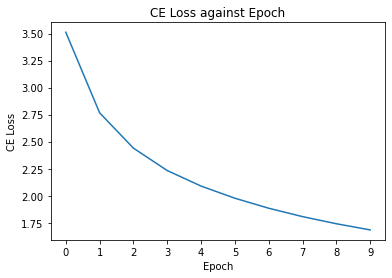

In [ ]:
# Model 1
layer_architecture = [
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture)
predictions = mlp.fit(X_train_standardized, y_train, epochs=10, use_minibatch=True, batch_size=128).predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n", acc)
mlp.plot_loss()

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]



 0.8112
-------
Layer 0
input_dim: 784
output_dim: 128
activation: ReLU
-------
Layer 1
input_dim: 128
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

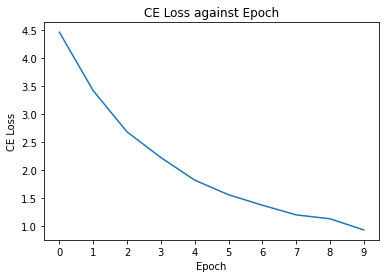

In [ ]:
# Model 2
layer_architecture = [
    Layer(n_units=128),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture)
predictions = mlp.fit(X_train_standardized, y_train, epochs=10, use_minibatch=True, batch_size=128).predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n", acc)
mlp.plot_loss()

100%|██████████| 10/10 [01:04<00:00,  6.43s/it]



 Train accuracy 0.7929666666666667

 Test accuracy 0.7635
-------
Layer 0
input_dim: 784
output_dim: 128
activation: ReLU
-------
Layer 1
input_dim: 128
output_dim: 128
activation: ReLU
-------
Layer 2
input_dim: 128
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

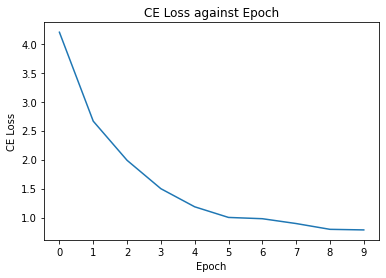

In [ ]:
# Model 3
layer_architecture = [
    Layer(n_units=128),
    Layer(n_units=128),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture)
predictions = mlp.fit(X_train_standardized, y_train, epochs=10, use_minibatch=True, batch_size=128).predict(X_train_standardized)
acc = MLP.evaluate_accuracy(predictions, y_train)
print("\n Train accuracy", acc)
predictions = mlp.predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n Test accuracy", acc)
mlp.plot_loss()

## Experiment 2: Compare Activation Functions

100%|██████████| 10/10 [01:45<00:00, 10.52s/it]



 0.1002
-------
Layer 0
input_dim: 784
output_dim: 128
activation: TanH
-------
Layer 1
input_dim: 128
output_dim: 128
activation: TanH
-------
Layer 2
input_dim: 128
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

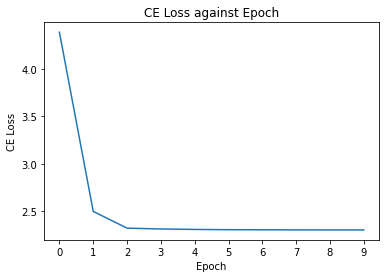

In [8]:
#Tanh
layer_architecture = [
    Layer(n_units=128, activation = "tanh"),
    Layer(n_units=128, activation = "tanh"),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture, learning_rate=0.001)
predictions = mlp.fit(X_train_standardized, y_train, epochs=10, use_minibatch=True, batch_size=128).predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n", acc)
mlp.plot_loss()

100%|██████████| 20/20 [01:14<00:00,  3.74s/it]



 0.7283
-------
Layer 0
input_dim: 784
output_dim: 128
activation: LeakyReLU
-------
Layer 1
input_dim: 128
output_dim: 128
activation: LeakyReLU
-------
Layer 2
input_dim: 128
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

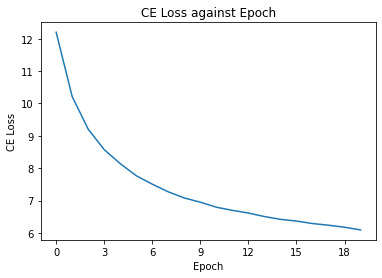

In [ ]:
# Leaky Relu
layer_architecture = [
    Layer(n_units=128, activation = "leaky_relu"),
    Layer(n_units=128, activation = "leaky_relu"),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture, learning_rate = 0.001)
predictions = mlp.fit(X_train_standardized, y_train, epochs=20, use_minibatch=True, batch_size=1024).predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n", acc)
mlp.plot_loss()

## Experiment 3: Add L2 Regularization

100%|██████████| 10/10 [00:50<00:00,  5.03s/it]



 Train accuracy 0.7878833333333334

 Test accuracy 0.7791
-------
Layer 0
input_dim: 784
output_dim: 128
activation: ReLU
-------
Layer 1
input_dim: 128
output_dim: 128
activation: ReLU
-------
Layer 2
input_dim: 128
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

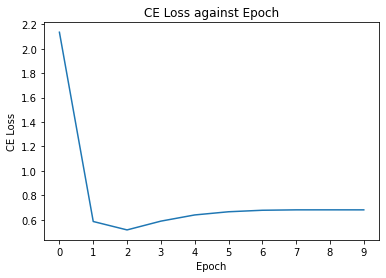

In [ ]:
#Same as Model 3 from Experiment 1 but with regularization
layer_architecture = [
    Layer(n_units=128),
    Layer(n_units=128),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture)
predictions = mlp.fit(X_train_standardized, y_train, epochs=10, use_minibatch=True, batch_size=128, l2=0.10).predict(X_train_standardized)
acc = MLP.evaluate_accuracy(predictions, y_train)
print("\n Train accuracy", acc)
predictions = mlp.predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n Test accuracy", acc)
mlp.plot_loss()

# Better generalization.
# Train accuracy decreased by 0.5%
# Test accuracy improved by 1.56%

## Experiment 4: Compare with Unnormalized Images

100%|██████████| 75/75 [04:07<00:00,  3.30s/it]



 0.7243
-------
Layer 0
input_dim: 784
output_dim: 128
activation: ReLU
-------
Layer 1
input_dim: 128
output_dim: 128
activation: ReLU
-------
Layer 2
input_dim: 128
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

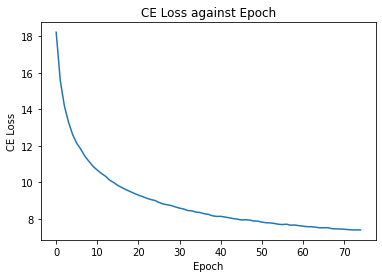

In [ ]:
layer_architecture = [
    Layer(n_units=128),
    Layer(n_units=128),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture, learning_rate = 0.000001)
predictions = mlp.fit(X_train_vectorized, y_train, epochs=75, use_minibatch=True, batch_size=512).predict(X_test_vectorized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n", acc)
mlp.plot_loss()

## Experiment 5: Compare with a Convolutional Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from keras.utils import to_categorical
from tensorflow.keras.layers import MaxPooling2D


In [ ]:
x_tf = X_train_standardized

#Convert to categorical one-hot-encoded y
y_tf= to_categorical(y_train)
y_tf_test = to_categorical(y_test)

In [ ]:
model = Sequential()

# 2 Convolutional Layer - Relu
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
# Flatten for input in Dense layer
model.add(Flatten())
#2 Hidden Layer - Relu and 128 units
model.add(Dense(128,activation="relu"))
model.add(Dense(128,activation="relu"))
#Softmax for categorical output
model.add(Dense(10,activation="softmax"))


In [ ]:
#compile model using accuracy to measure model performance, using the default best optimizer.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#train the model and do the prediction on test data under "validation_data" - accuracy around 89-90% at Epoch 5 (with kernel and pooling at 2)
model.fit(X_train, y_tf, validation_data=(X_test, y_tf_test), epochs=20)

Epoch 1/20
1875/1875 [==============================] - 53s 26ms/step - loss: 0.6437 - accuracy: 0.8254 - val_loss: 0.4067 - val_accuracy: 0.8552
Epoch 2/20
1875/1875 [==============================] - 39s 21ms/step - loss: 0.3283 - accuracy: 0.8807 - val_loss: 0.3331 - val_accuracy: 0.8805
Epoch 3/20
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2856 - accuracy: 0.8955 - val_loss: 0.3124 - val_accuracy: 0.8885
Epoch 4/20
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2569 - accuracy: 0.9051 - val_loss: 0.2901 - val_accuracy: 0.8939
Epoch 5/20
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2346 - accuracy: 0.9131 - val_loss: 0.2939 - val_accuracy: 0.8921
Epoch 6/20
1875/1875 [==============================] - 38s 20ms/step - loss: 0.2128 - accuracy: 0.9201 - val_loss: 0.2974 - val_accuracy: 0.8987
Epoch 7/20
1875/1875 [==============================] - 40s 22ms/step - loss: 0.1960 - accuracy: 0.9273 - val_loss: 0.3045 -

## Experiment 6: Compare Optimal MLP Architecture with ConvNet

100%|██████████| 20/20 [02:28<00:00,  7.43s/it]



 Train accuracy 0.8384666666666667

 Test accuracy 0.8244
-------
Layer 0
input_dim: 784
output_dim: 256
activation: ReLU
-------
Layer 1
input_dim: 256
output_dim: 10
activation: Softmax
-------


<Figure size 432x288 with 0 Axes>

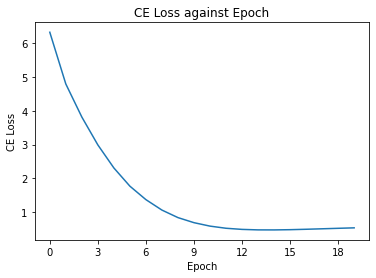

In [6]:
# Optimal MLP architecture
layer_architecture = [
    Layer(n_units=256),
    Layer(n_units=10)
    ]
mlp = MLP(*layer_architecture, learning_rate=0.005)
predictions = mlp.fit(X_train_standardized, y_train, epochs=20, use_minibatch=True, batch_size=256, l2=0.10).predict(X_train_standardized)
acc = MLP.evaluate_accuracy(predictions, y_train)
print("\n Train accuracy", acc)
predictions = mlp.predict(X_test_standardized)
acc = MLP.evaluate_accuracy(predictions, y_test)
print("\n Test accuracy", acc)
mlp.plot_loss()

In [7]:
predictions

array([9, 2, 1, ..., 8, 1, 5])

## Extra Experiments

100%|██████████| 10/10 [02:16<00:00, 13.70s/it]


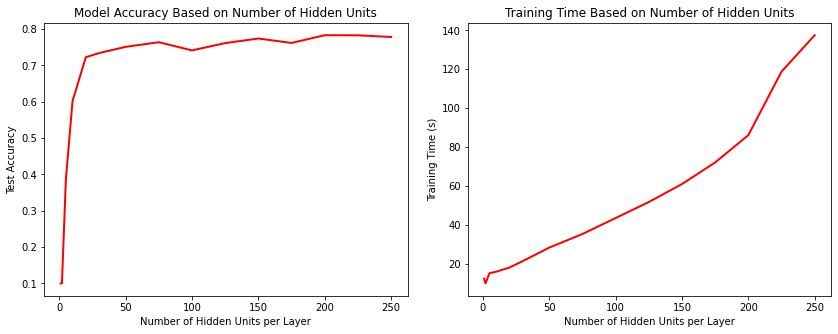

In [ ]:
# Compare the accuracy and training time of the model when using different numbers of hidden units per layer. 
num_hidden_units = [1, 2, 5, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250]
accuracies = []
times = []

for num in num_hidden_units:
  layer_architecture = [
      Layer(n_units=num),
      Layer(n_units=num),
      Layer(n_units=10)
      ]
  mlp = MLP(*layer_architecture)
  start_time = time.time()
  predictions = mlp.fit(X_train_standardized, y_train, epochs=10, use_minibatch=True, batch_size=128).predict(X_test_standardized)
  acc = MLP.evaluate_accuracy(predictions, y_test)
  end_time = time.time()
  accuracies.append(acc)
  times.append(end_time - start_time)

# Plot the accuracies
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(num_hidden_units, accuracies, "red", lw=2)
plt.xlabel('Number of Hidden Units per Layer')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Based on Number of Hidden Units')

# Plot the training times
plt.subplot(1, 2, 2)
plt.plot(num_hidden_units, times, "red", lw=2)
plt.xlabel('Number of Hidden Units per Layer')
plt.ylabel('Training Time (s)')
plt.title('Training Time Based on Number of Hidden Units')
plt.tight_layout(2)
plt.show()

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Text(0.5, 1.0, 'Model Accuracy Based on Number of Training Points')

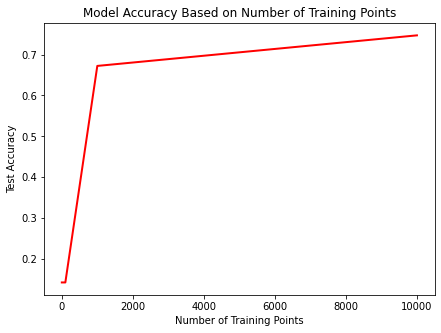

In [27]:
# Compare the accuracy when using 10^k, k ∈ {0, 1, 2, 3, 4} images on the MLP. 
possible_k = [0, 1, 2, 3, 4]
num_points = [1, 10, 100, 1000, 10000]
mlp_accuracies = []

for k in possible_k:
  layer_architecture = [
      Layer(n_units=128),
      Layer(n_units=128),
      Layer(n_units=10)
      ]
  mlp = MLP(*layer_architecture)
  predictions = mlp.fit(X_train_standardized[0:10 ** k], y_train[0:10 ** k], epochs=10, use_minibatch=True, batch_size=128).predict(X_test_standardized)
  acc = MLP.evaluate_accuracy(predictions, y_test)
  mlp_accuracies.append(acc)

# Plot the accuracies
plt.subplots(figsize=(7, 5))
plt.plot(num_points, mlp_accuracies, "red", lw=2)
plt.xlabel('Number of Training Points')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Based on Number of Training Points')